<br>
<b>
    <font size="10" face="verdana">AI Fall 98 Final</font>
</b>
<hr>

## By Parsa Hoseininejad

In [1]:
from __future__ import unicode_literals
import pandas as pd
import matplotlib.pyplot as plt
import hazm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import numpy as np
import sklearn
import itertools

## Data
Raw dataset with it's columns is shown in the part below.

In [2]:
df = pd.read_csv('mobile_phone_dataset.csv', delimiter = ',')
df

,Unnamed: 0,brand,city,title,desc,image_count,created_at,price
0,0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,Wednesday 07AM,60000
1,1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,Wednesday 11AM,1150000
2,2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,Wednesday 02PM,590000
3,3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,Wednesday 04PM,1100000
4,4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,Friday 01PM,900000
...,...,...,...,...,...,...,...,...
59184,62171,Apple::اپل,Tehran,گوشی موبایل ایفون(4S (32GB,گوشی موبایل ایفون 4S\n32 گیگ سفید سالم دکمه هو...,3,Tuesday 03PM,500000
59185,62172,LG::ال‌جی,Mashhad,گوشی ال جی k10تمیزومرتب بدون خط وخش,گوشی ال جی سالم وبدون کوچکترین ایرادوبدون خط و...,3,Tuesday 05PM,520000
59186,62173,Apple::اپل,Tehran,/١٦gig/5s/گلد,جعبه ولوازم LLAاصل/بدون خط وخش/باز نشده/سالم.,2,Wednesday 11AM,720000
59187,62174,Samsung::سامسونگ,Tehran,گلکسی galaxy s4 i9500,سالم و تمیز با لوازم\nاندروید 5. باتری اورجینا...,2,Thursday 09AM,475000


## Dataset Preprocessing
To turn this data set to useful data, three major steps are done:<br>
1. __Date processing__: Date given in the data set is a string which contains day and hour. As we know, this string should be converted to numeric data to build a model based on it. After itertaing on the dataframe, day of week and huor are added to the dataframe. These attributes can help us determine the price. However, it is unlikely that these feautures have effect on the price since they are irrelavant. This effect will be studied later.
2. __One Hot Encoding__: In order to process categorical data, like Country column in this case, it should be converted to numeric data. One approach is to use one hot encoding which adds a column for each category and determins that category by 0 and 1 values. The drawback of this approach is that it would take a lot of memory since there are multiple columns added to the table. Another approach is to use label encoding. In this approach, each category will be labeled with an integer bigger than 0. The problem here is that different categories will get different numeric numbers and the model would be trained based on this value which is not desired. Thus, one hot encoding is used.
3. __Dropping Columns__: Some columns are dropped later because their information gain is low. This dropping will be done in further parts.
4. __Text Preprocessing__: In order to extract useful data from description and title columns, they should be tokenized and processed. This will be explained in further parts.

In [3]:
import calendar

d = dict(zip(calendar.day_name,range(7)))
days = []
hours = []
for index, row in df.iterrows():
    day = row['created_at'][:-5]
    hour = row['created_at'][-4:-2]
    temp = row['created_at'][-2:]
    days.append(d[day])
    if temp == 'PM':
        hours.append(12 + int(hour))
    else:
        hours.append(int(hour))
        
df['Day of Week'] = days
df['Hour'] = hours

df.drop(columns=['created_at', 'Unnamed: 0'], inplace=True)
    
df

,brand,city,title,desc,image_count,price,Day of Week,Hour
0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,60000,2,7
1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,1150000,2,11
2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,590000,2,14
3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,1100000,2,16
4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,900000,4,13
...,...,...,...,...,...,...,...,...
59184,Apple::اپل,Tehran,گوشی موبایل ایفون(4S (32GB,گوشی موبایل ایفون 4S\n32 گیگ سفید سالم دکمه هو...,3,500000,1,15
59185,LG::ال‌جی,Mashhad,گوشی ال جی k10تمیزومرتب بدون خط وخش,گوشی ال جی سالم وبدون کوچکترین ایرادوبدون خط و...,3,520000,1,17
59186,Apple::اپل,Tehran,/١٦gig/5s/گلد,جعبه ولوازم LLAاصل/بدون خط وخش/باز نشده/سالم.,2,720000,2,11
59187,Samsung::سامسونگ,Tehran,گلکسی galaxy s4 i9500,سالم و تمیز با لوازم\nاندروید 5. باتری اورجینا...,2,475000,3,9


## Oversampling
As seen in the below plots, data is not distributed equally between classes. To remove its effects, brand distributinos is equalled using oversampling. Note that I didn't over sample citys because their information gain is low and brand is much more important

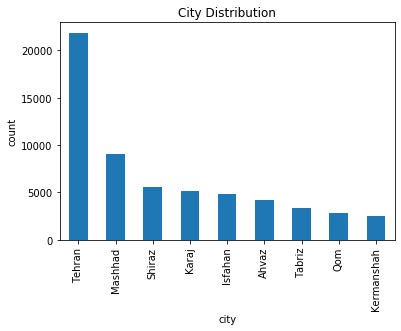

In [4]:
fig, ax = plt.subplots()
plt.xlabel('city')
plt.ylabel('count')
plt.title('City Distribution')
df['city'].value_counts().plot(ax=ax, kind='bar')
plt.show()

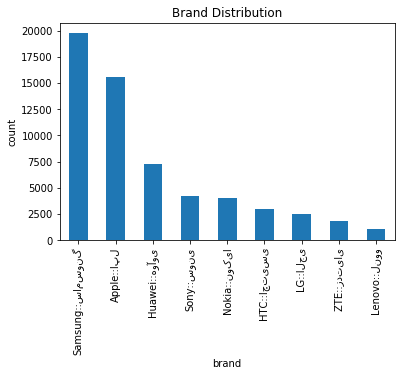

In [5]:
fig, ax = plt.subplots()
plt.xlabel('brand')
plt.ylabel('count')
plt.title('Brand Distribution')
df['brand'].value_counts().plot(ax=ax, kind='bar')
plt.show()

In [6]:
df = pd.concat([df, df.loc[(df['brand'] != 'Samsung::سامسونگ') & (df['brand'] != 'Apple::اپل')]], ignore_index=True)
df = pd.concat([df, df.loc[(df['brand'] == 'HTC::اچ‌تی‌سی') | (df['brand'] == 'ZTE::زدتی‌ای') | (df['brand'] == 'LG::ال‌جی') | (df['brand'] == 'Lenovo::لنوو')]], ignore_index=True)
df = pd.concat([df, df.loc[(df['brand'] == 'ZTE::زدتی‌ای') | (df['brand'] == 'Lenovo::لنوو')]], ignore_index=True)
df = pd.concat([df, df.loc[(df['brand'] == 'LG::ال‌جی') | (df['brand'] == 'Lenovo::لنوو') | (df['brand'] == 'Sony::سونی') | (df['brand'] == 'Nokia::نوکیا')]], ignore_index=True)

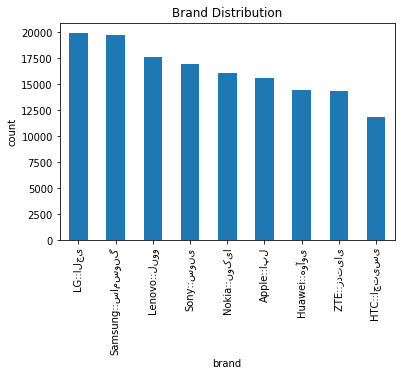

In [7]:
fig, ax = plt.subplots()
plt.xlabel('brand')
plt.ylabel('count')
plt.title('Brand Distribution')
df['brand'].value_counts().plot(ax=ax, kind='bar')
plt.show()

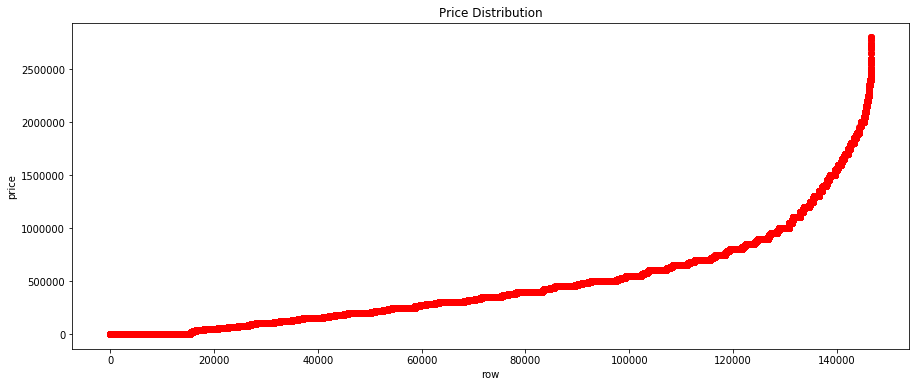

In [8]:
row = df['price'].tolist()
row.sort()
plt.figure(figsize=(15,6))
plt.plot(row, 'ro')
plt.xlabel('row')
plt.ylabel('price')
plt.title('Price Distribution')
plt.show()

In this part, noisy data is removed. In order to delete noisy data, phones with price less than 10,000 Toman are dropped because their price is not logical and there are up to 400 of these kind of data so dropping them won't harm the dataset. Furthermore, some rows have -1 as their price. Since there are 6000 rows with this condition, they can't be dropped. Instead, average price of their brand is replaced with -1.

In [9]:
df.drop(df[(df['price'] != -1) & (df['price'] < 10000)].index, inplace=True)
df = df.replace(-1, np.nan)
df['price'] = df.groupby('brand')['price'].transform(lambda group: group.fillna(np.mean(group)))

In [10]:
df = pd.concat([df, pd.get_dummies(df['brand'], prefix='brand')], axis=1)
df = pd.concat([df, pd.get_dummies(df['city'], prefix='city')], axis=1)
df.drop(columns=['city', 'brand'], inplace=True)
df

,title,desc,image_count,price,Day of Week,Hour,brand_Apple::اپل,brand_HTC::اچ‌تی‌سی,brand_Huawei::هوآوی,brand_LG::ال‌جی,...,brand_ZTE::زدتی‌ای,city_Ahvaz,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran
0,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,6.000000e+04,2,7,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,1.150000e+06,2,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,5.900000e+05,2,14,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,1.100000e+06,2,16,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,9.000000e+05,4,13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146594,گوشی موبایل هوآوی,گوشی موبایل هوآوی گولد x4 honor،کاملا سالم بد...,2,4.500000e+05,1,16,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
146595,میت8هواوی,گوشی در حد اک بدون نقطه قیمت بدون کوچکترین تخف...,2,1.100000e+06,2,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
146596,هواوی G8,۲ماه کارکرده\nمعاوضه ندارم لطفا انقد نگید\nاند...,3,7.300000e+05,1,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
146597,گوشی honor3clait16gig,گوشی رو4ماه خریدم بسیارتمییییییییز وخوش دستی ب...,3,3.200000e+05,3,20,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Information Gain
In information theory and machine learning, information gain is the amount of information gained about a random variable or signal from observing another random variable. As observed in the information gain plot, the __Price__ attribute is more realated to some attributes such as brand. However, some other attributes such as image count, day of week and hour have low information gains and thus could be dropped from table.

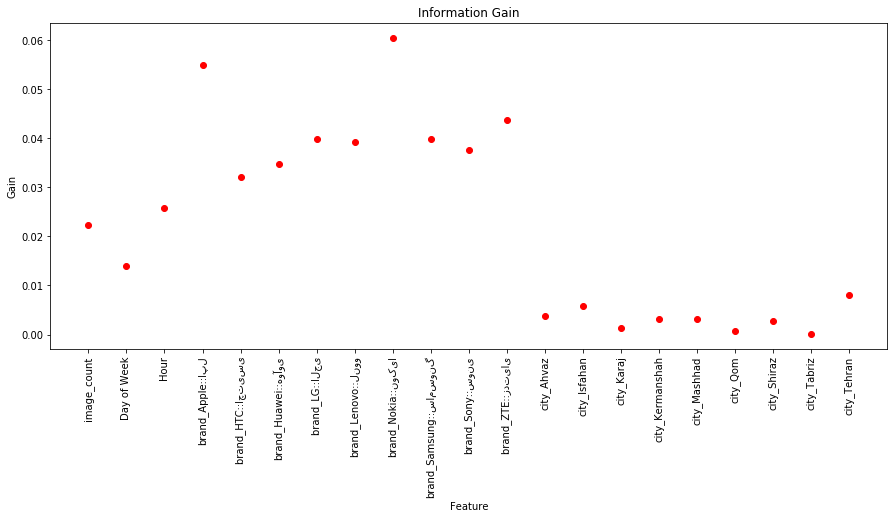

In [11]:
from sklearn import feature_selection

dfTemp = df.drop(columns=['title', 'desc', 'price'])
dfAnsTemp = df['price']

ansCategorical = []
for price in dfAnsTemp.values.tolist():
    ansCategorical.append(int(price % 100000))

plt.figure(figsize=(15,6))
plt.plot(sklearn.feature_selection.mutual_info_classif(dfTemp.values.tolist(), ansCategorical), 'ro')
plt.xticks(np.arange(len(list(dfTemp.columns.values))), list(dfTemp.columns.values), rotation=90)
plt.xlabel('Feature')
plt.ylabel('Gain')
plt.title('Information Gain')
plt.show()

In [12]:
df.drop(columns=['Day of Week', 'Hour', 'image_count'], inplace=True)
df

,title,desc,price,brand_Apple::اپل,brand_HTC::اچ‌تی‌سی,brand_Huawei::هوآوی,brand_LG::ال‌جی,brand_Lenovo::لنوو,brand_Nokia::نوکیا,brand_Samsung::سامسونگ,...,brand_ZTE::زدتی‌ای,city_Ahvaz,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran
0,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,6.000000e+04,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,1.150000e+06,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,5.900000e+05,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,1.100000e+06,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,9.000000e+05,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146594,گوشی موبایل هوآوی,گوشی موبایل هوآوی گولد x4 honor،کاملا سالم بد...,4.500000e+05,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
146595,میت8هواوی,گوشی در حد اک بدون نقطه قیمت بدون کوچکترین تخف...,1.100000e+06,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
146596,هواوی G8,۲ماه کارکرده\nمعاوضه ندارم لطفا انقد نگید\nاند...,7.300000e+05,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
146597,گوشی honor3clait16gig,گوشی رو4ماه خریدم بسیارتمییییییییز وخوش دستی ب...,3.200000e+05,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


## Text Preprocessing
To turn this data set to useful data, four major steps are done:

1. Deleting stop words: Stop words are a set of commonly used words in any language. For example, in English, “the”, “is” and “and”, would easily qualify as stop words. These kinds of words are unimportant and they are removed to allow the model to focus on the important words instead.
2. Tokenizing: To tokenize the texts, non alphabetic characters are used as delimiters.
3. Lemmatization: Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. For instance, "stones" and "stone" are both interpreted as "stone". Because these two words have the same root, it is essential to calculate the frequency of this word by adding both previous frequencies. In this project, lemmatization is preferred over Stemming because lemmatization does morphological analysis of the words.
4. Normalization: In order to fix spacing in texts, <code>affix_spacing</code> method is used to handle full and half spaces in Farsi language.

In [13]:
def cleanData(colName):
    tokenizer = hazm.WordTokenizer()
    lemmatizer = hazm.Lemmatizer()
    normalizer = hazm.Normalizer()
    englishStopWords = set(stopwords.words('english'))
    farsiStopWords = set(hazm.utils.stopwords_list())
    stopWords = englishStopWords.union(farsiStopWords)
    stopWords = stopWords.union({'ی', 'ای', ',', '،', ')', '(', ':', ';', '-', '_', 'g', '.', 'گوش', '/'})
    wordsCol = []

    for index, row in df.iterrows():
        desciption = row[colName]
        normalizedText = normalizer.affix_spacing(desciption)
        words = tokenizer.tokenize(desciption)
        filteredWords = [lemmatizer.lemmatize(w.lower()) for w in words if not w in stopWords]
        wordsCol.append(filteredWords)

    df.drop([colName], axis=1, inplace=True)
    df[colName + ' words'] = wordsCol
    return df

In [14]:
df = cleanData('desc')
df = cleanData('title')
df

,price,brand_Apple::اپل,brand_HTC::اچ‌تی‌سی,brand_Huawei::هوآوی,brand_LG::ال‌جی,brand_Lenovo::لنوو,brand_Nokia::نوکیا,brand_Samsung::سامسونگ,brand_Sony::سونی,brand_ZTE::زدتی‌ای,...,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran,desc words,title words
0,6.000000e+04,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,"[سلام, یه, گوشیه, 6303, سالم, دوتا, خط, کوچیک,...","[نوکیا, 6303]"
1,1.150000e+06,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,"[درحد, نو, سالم, اصلى, ضربه, مهلت, تست, میدم]","[ایفون, ٥اس, ٣٢, گیگ]"
2,5.900000e+05,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,"[گوشى, تمیز, هفته, کارکرده, آک]","[سامسونگ, j5]"
3,1.100000e+06,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,"[گلس, کارت, اپل, دی, لوازم, جانبی, اصل, معاوضه...","[گرى, 5s, ایفون, 32, گیگ]"
4,9.000000e+05,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,"[تمیز, 1, خط, خش, همراه, گلاس, قاب, محافظ]","[galaxy, s5, gold, آک]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146594,4.500000e+05,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,"[گوش, موبایل, هوآوی, گولد, x4, honor, سالم, تع...","[گوش, موبایل, هوآوی]"
146595,1.100000e+06,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,"[گوش, اک, نقطه, قیمت, کوچک, تخفیف]",[میت8هواوی]
146596,7.300000e+05,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,"[۲ماه, کارکرده, معاوضه, داشت#دار, لطفا, انقد, ...","[هواوی, g8]"
146597,3.200000e+05,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,"[گوش, رو4ماه, خرید#خر, بسیارتمییییییییز, وخوش,...","[گوش, honor3clait, 16, gig]"


### Data Spliting
The data is split into two parts. One part is used to build and train the model and one part is used to evaluate the built model. The random_state attribute is set to a number to remove randomness. 0.2 of the data is used as test data and the rest are used to train our model.

In [15]:
from sklearn.model_selection import train_test_split

trainData, testData, trainAns, testAns = train_test_split(df.drop(columns=['price']), df['price'], test_size=0.2, random_state=32)
print('Train length is ' + str(len(trainData)) + ' and test size is ' + str(len(testData)))

Train length is 116788 and test size is 29198


### Words as Features
In order to make use of title and description columns, each of these columns are broken into their containing words. Now, count of each word is calculated and the top 200 words are counted as features. To use these features, one hot encoding is used.

In [16]:
titleDict = {}
descDict = {}

for index, row in trainData.iterrows():
    for word in row['desc words']:
        if word in descDict:
            descDict[word] += 1
        else:
            descDict[word] = 1
    
    for word in row['title words']:
        if word in titleDict:
            titleDict[word] += 1
        else:
            titleDict[word] = 1
            
titleDict = {k: v for k, v in sorted(titleDict.items(), key=lambda item: item[1], reverse=True)}
descDict = {k: v for k, v in sorted(descDict.items(), key=lambda item: item[1], reverse=True)}
del titleDict['گوش']
del descDict['گوش']

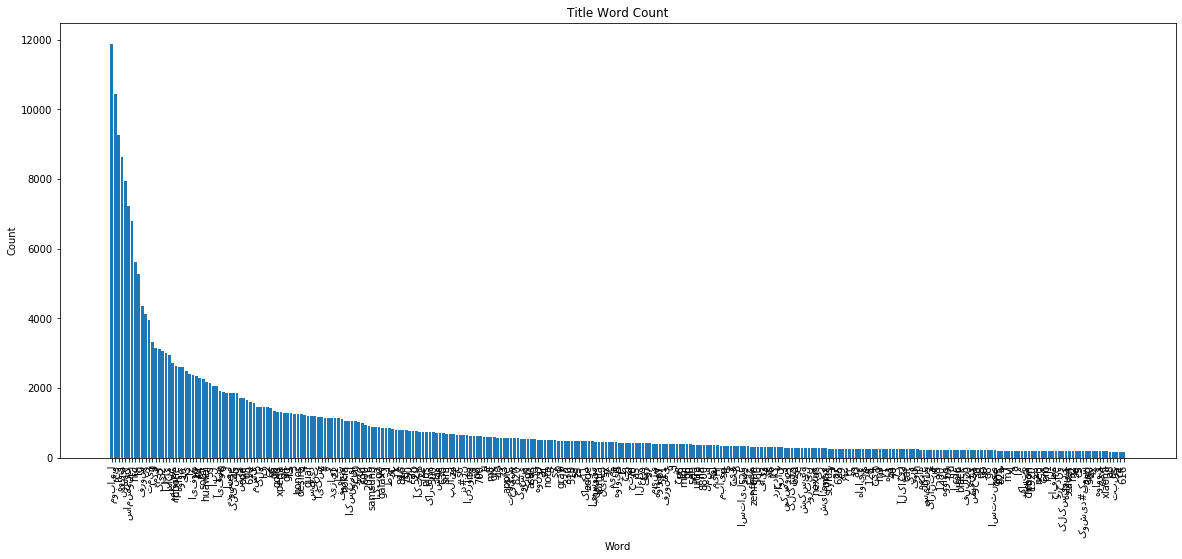

In [17]:
titlePart = dict(itertools.islice(titleDict.items(), 300))

plt.figure(figsize=(20,8))
plt.bar(range(len(titlePart)), list(titlePart.values()))
plt.xticks(range(len(titlePart)), list(titlePart.keys()), rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Title Word Count')
plt.show()

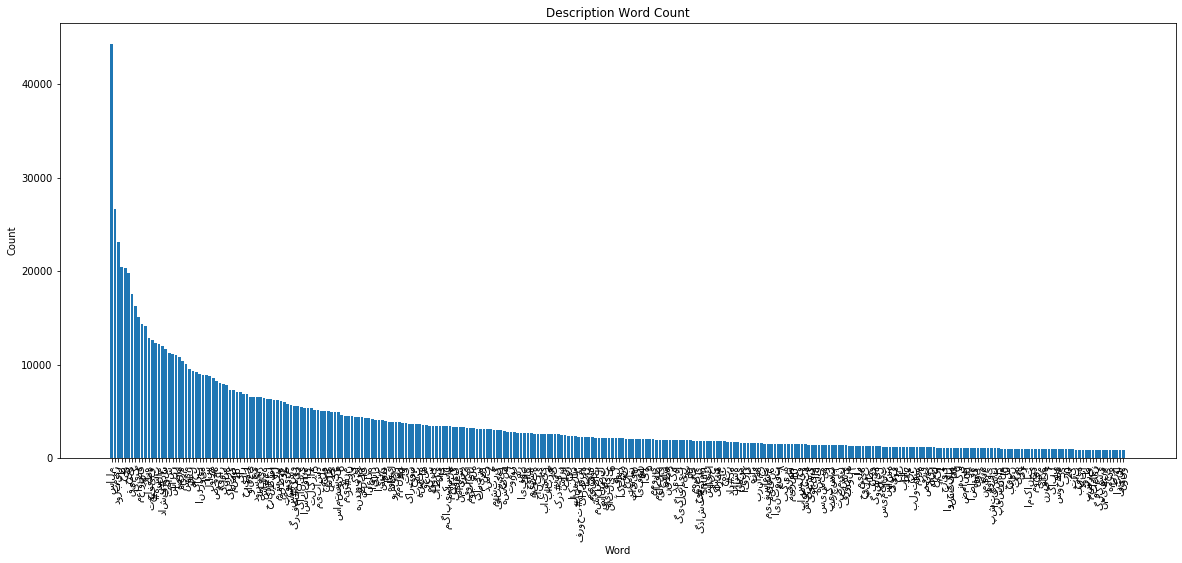

In [18]:
descPart = dict(itertools.islice(descDict.items(), 300))

plt.figure(figsize=(20,8))
plt.bar(range(len(descPart)), list(descPart.values()))
plt.xticks(range(len(descPart)), list(descPart.keys()), rotation='vertical')
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Description Word Count')
plt.show()

In [19]:
def oneHotDict(colName, partDict, prefix):
    for key in partDict:
        trainData[prefix + '_' + key] = 0
        trainData[prefix + '_' + key] = trainData[colName].apply(lambda x : 1 if key in x else 0)
        
        testData[prefix + '_' + key] = 0
        testData[prefix + '_' + key] = testData[colName].apply(lambda x : 1 if key in x else 0) 

In [20]:
oneHotDict('title words', titlePart, 'title')
oneHotDict('desc words', descPart, 'desc')
trainData.drop(columns=['desc words', 'title words'], inplace=True)
testData.drop(columns=['desc words', 'title words'], inplace=True)
trainData

,brand_Apple::اپل,brand_HTC::اچ‌تی‌سی,brand_Huawei::هوآوی,brand_LG::ال‌جی,brand_Lenovo::لنوو,brand_Nokia::نوکیا,brand_Samsung::سامسونگ,brand_Sony::سونی,brand_ZTE::زدتی‌ای,city_Ahvaz,...,desc_الان,desc_وتمیز,desc_گلکسی,desc_نمیکنم,desc_4جی,desc_همرده,desc_طرح,desc_ارتقا,desc_فیس,desc_نونو
31200,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98772,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
144853,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58469,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
43343,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60652,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75469,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
131537,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
108595,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Learning
<hr>

### Linear Regression
The overall idea of regression is to examine two things: (1) does a set of predictor variables do a good job in predicting an outcome (dependent) variable?  (2) Which variables in particular are significant predictors of the outcome variable, and in what way do they–indicated by the magnitude and sign of the beta estimates–impact the outcome variable?  These regression estimates are used to explain the relationship between one dependent variable and one or more independent variables.  The simplest form of the regression equation with one dependent and one independent variable is defined by the formula y = c + b*x, where y = estimated dependent variable score, c = constant, b = regression coefficient, and x = score on the independent variable.<br>
<img src='assets/linear.png' width=400/>

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

regr = LinearRegression().fit(trainData, trainAns)
pred = regr.predict(testData)

print('Mean squared error: %.2f' % np.sqrt(mean_squared_error(testAns, pred)))

Mean squared error: 260042.20


### Ridge Regression
Ridge regression is one of the simple techniques to reduce model complexity and prevent over-fitting which may result from simple linear regression. Ridge regression puts constraint on the coefficients. The penalty term  regularizes the coefficients such that if the coefficients take large values the optimization function is penalized. So, ridge regression shrinks the coefficients and it helps to reduce the model complexity. Note that here we use λ, scikit-learn uses α. β  is a vector of weights.<br>
<img src='assets/ridge.jpg' width=600/>
<br>
In each step of a gradient search we move the model parameters in the direction of the gradient. As seen in the code, we tried to tune α and the best α for this case is 5.

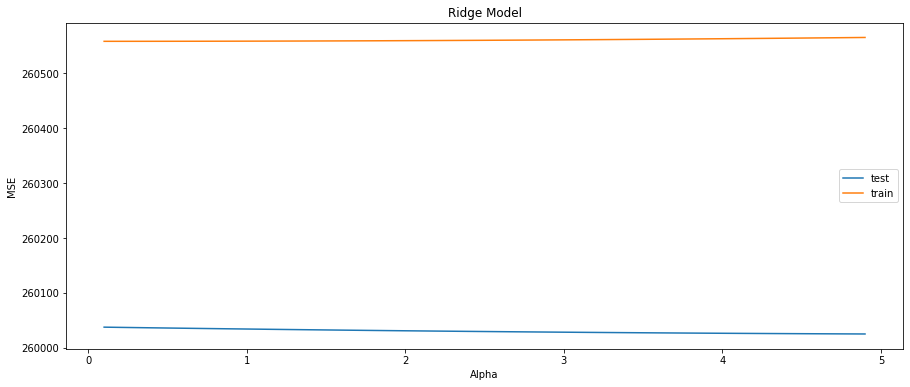

In [22]:
from sklearn.linear_model import Ridge

testAccuracies = []
trainAccuracies = []
for i in np.arange(0.1, 5.0, 0.1):
    clf = Ridge(alpha=i)
    regr = clf.fit(trainData, trainAns)
    pred = regr.predict(testData)
    testAccuracies.append(np.sqrt(mean_squared_error(testAns, pred)))
    
    pred = regr.predict(trainData)
    trainAccuracies.append(np.sqrt(mean_squared_error(trainAns, pred)))

plt.figure(figsize=(15,6))
plt.plot(np.arange(0.1, 5.0, 0.1), testAccuracies, label='test')
plt.plot(np.arange(0.1, 5.0, 0.1), trainAccuracies, label='train')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Ridge Model')
plt.legend()
plt.show()

### Random Forest Regressor
A Random Forest is an ensemble technique capable of performing both regression and classification tasks with the use of multiple decision trees and a technique called Bootstrap and Aggregation, commonly known as bagging. The basic idea behind this is to combine multiple decision trees in determining the final output rather than relying on individual decision trees.<br>
Random Forest has multiple decision trees as base learning models. We randomly perform row sampling and feature sampling from the dataset forming sample datasets for every model.<br>
In this case, max depth of the model is tuned and as seen in the plot, as the depth grows, mse decreases. However, it takes too long for this model to be built so bigger depths are not tested.

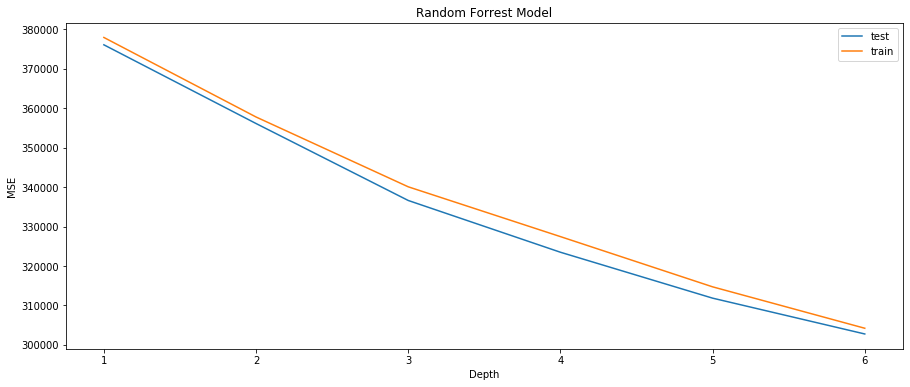

In [23]:
from sklearn.ensemble import RandomForestRegressor

testAccuracies = []
trainAccuracies = []
for i in range(1, 7):
    regr = RandomForestRegressor(max_depth=i, random_state=0)
    regr = regr.fit(trainData, trainAns)
    pred = regr.predict(testData)
    testAccuracies.append(np.sqrt(mean_squared_error(testAns, pred)))
    
    pred = regr.predict(trainData)
    trainAccuracies.append(np.sqrt(mean_squared_error(trainAns, pred)))

plt.figure(figsize=(15,6))
plt.plot(range(1, 7), testAccuracies, label='test')
plt.plot(range(1, 7), trainAccuracies, label='train')
plt.xlabel('Depth')
plt.ylabel('MSE')
plt.title('Random Forrest Model')
plt.legend()
plt.show()

### Light GBM Regressor
Light GBM is a gradient boosting framework that uses tree based learning algorithm. Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.<br>
As observed in the plot, the model is starting to overfit after lr=0.3 which is logical. Other hyper parameter are tuned by examining. early_stopping_rounds=5 also means if the model doesn't improve after 5 round, training will be stopped. <br>
In order to build this model, these parameters are tunes:
1. learning_rate: This determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitude of this change in the estimates.
2. num_leaves: number of leaves in full tree
3. min_data_in_leaf:  It is the minimum number of the records a leaf may have.
4. max_depth: It describes the maximum depth of tree. This parameter is used to handle model overfitting.
5. n_estimators: number of trees in the foreset.<br>


[1]	valid_0's l1: 324939	valid_0's l2: 1.90584e+11
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 322975	valid_0's l2: 1.88236e+11
[3]	valid_0's l1: 321032	valid_0's l2: 1.85933e+11
[4]	valid_0's l1: 319114	valid_0's l2: 1.83685e+11
[5]	valid_0's l1: 317223	valid_0's l2: 1.81487e+11
[6]	valid_0's l1: 315350	valid_0's l2: 1.79326e+11
[7]	valid_0's l1: 313494	valid_0's l2: 1.772e+11
[8]	valid_0's l1: 311667	valid_0's l2: 1.75122e+11
[9]	valid_0's l1: 309861	valid_0's l2: 1.73084e+11
[10]	valid_0's l1: 308073	valid_0's l2: 1.7109e+11
[11]	valid_0's l1: 306315	valid_0's l2: 1.69133e+11
[12]	valid_0's l1: 304569	valid_0's l2: 1.67206e+11
[13]	valid_0's l1: 302854	valid_0's l2: 1.65331e+11
[14]	valid_0's l1: 301150	valid_0's l2: 1.63484e+11
[15]	valid_0's l1: 299461	valid_0's l2: 1.61668e+11
[16]	valid_0's l1: 297801	valid_0's l2: 1.59897e+11
[17]	valid_0's l1: 296176	valid_0's l2: 1.58148e+11
[18]	valid_0's l1: 294578	valid_0's l2: 1.5644e+11
[19]	valid_0's l1

[1]	valid_0's l1: 313068	valid_0's l2: 1.76717e+11
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 300405	valid_0's l2: 1.62674e+11
[3]	valid_0's l1: 288860	valid_0's l2: 1.50442e+11
[4]	valid_0's l1: 278382	valid_0's l2: 1.39731e+11
[5]	valid_0's l1: 268783	valid_0's l2: 1.30396e+11
[6]	valid_0's l1: 259954	valid_0's l2: 1.22294e+11
[7]	valid_0's l1: 252199	valid_0's l2: 1.15384e+11
[8]	valid_0's l1: 244928	valid_0's l2: 1.09184e+11
[9]	valid_0's l1: 238286	valid_0's l2: 1.0374e+11
[10]	valid_0's l1: 231744	valid_0's l2: 9.87344e+10
[11]	valid_0's l1: 226352	valid_0's l2: 9.46345e+10
[12]	valid_0's l1: 221060	valid_0's l2: 9.09457e+10
[13]	valid_0's l1: 216077	valid_0's l2: 8.75881e+10
[14]	valid_0's l1: 211821	valid_0's l2: 8.47103e+10
[15]	valid_0's l1: 207856	valid_0's l2: 8.20562e+10
[16]	valid_0's l1: 204193	valid_0's l2: 7.97582e+10
[17]	valid_0's l1: 200681	valid_0's l2: 7.75194e+10
[18]	valid_0's l1: 197640	valid_0's l2: 7.5668e+10
[19]	valid_0's 

[1]	valid_0's l1: 301376	valid_0's l2: 1.63721e+11
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 280171	valid_0's l2: 1.41611e+11
[3]	valid_0's l1: 262130	valid_0's l2: 1.24272e+11
[4]	valid_0's l1: 247240	valid_0's l2: 1.11211e+11
[5]	valid_0's l1: 234547	valid_0's l2: 1.00955e+11
[6]	valid_0's l1: 224123	valid_0's l2: 9.31822e+10
[7]	valid_0's l1: 214915	valid_0's l2: 8.67429e+10
[8]	valid_0's l1: 207300	valid_0's l2: 8.17394e+10
[9]	valid_0's l1: 200744	valid_0's l2: 7.76723e+10
[10]	valid_0's l1: 194825	valid_0's l2: 7.41515e+10
[11]	valid_0's l1: 189734	valid_0's l2: 7.12851e+10
[12]	valid_0's l1: 185728	valid_0's l2: 6.90638e+10
[13]	valid_0's l1: 181040	valid_0's l2: 6.67474e+10
[14]	valid_0's l1: 178021	valid_0's l2: 6.50345e+10
[15]	valid_0's l1: 174993	valid_0's l2: 6.34551e+10
[16]	valid_0's l1: 172523	valid_0's l2: 6.22445e+10
[17]	valid_0's l1: 170347	valid_0's l2: 6.11615e+10
[18]	valid_0's l1: 168472	valid_0's l2: 6.02649e+10
[19]	valid_0'

[1]	valid_0's l1: 290029	valid_0's l2: 1.51595e+11
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 262007	valid_0's l2: 1.24175e+11
[3]	valid_0's l1: 240281	valid_0's l2: 1.05567e+11
[4]	valid_0's l1: 223693	valid_0's l2: 9.29231e+10
[5]	valid_0's l1: 210622	valid_0's l2: 8.40547e+10
[6]	valid_0's l1: 200108	valid_0's l2: 7.74548e+10
[7]	valid_0's l1: 191899	valid_0's l2: 7.25226e+10
[8]	valid_0's l1: 185366	valid_0's l2: 6.88986e+10
[9]	valid_0's l1: 179239	valid_0's l2: 6.58258e+10
[10]	valid_0's l1: 174971	valid_0's l2: 6.35368e+10
[11]	valid_0's l1: 171099	valid_0's l2: 6.16103e+10
[12]	valid_0's l1: 167820	valid_0's l2: 6.00135e+10
[13]	valid_0's l1: 165141	valid_0's l2: 5.87624e+10
[14]	valid_0's l1: 162789	valid_0's l2: 5.77268e+10
[15]	valid_0's l1: 161336	valid_0's l2: 5.6974e+10
[16]	valid_0's l1: 159917	valid_0's l2: 5.62541e+10
[17]	valid_0's l1: 158124	valid_0's l2: 5.5303e+10
[18]	valid_0's l1: 157185	valid_0's l2: 5.49005e+10
[19]	valid_0's 

[1]	valid_0's l1: 278989	valid_0's l2: 1.4034e+11
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 245843	valid_0's l2: 1.10285e+11
[3]	valid_0's l1: 222924	valid_0's l2: 9.2412e+10
[4]	valid_0's l1: 206798	valid_0's l2: 8.16924e+10
[5]	valid_0's l1: 194808	valid_0's l2: 7.43993e+10
[6]	valid_0's l1: 185644	valid_0's l2: 6.93558e+10
[7]	valid_0's l1: 177506	valid_0's l2: 6.4985e+10
[8]	valid_0's l1: 172722	valid_0's l2: 6.25229e+10
[9]	valid_0's l1: 168780	valid_0's l2: 6.06709e+10
[10]	valid_0's l1: 165458	valid_0's l2: 5.89336e+10
[11]	valid_0's l1: 163413	valid_0's l2: 5.79719e+10
[12]	valid_0's l1: 160332	valid_0's l2: 5.63692e+10
[13]	valid_0's l1: 158758	valid_0's l2: 5.56572e+10
[14]	valid_0's l1: 157352	valid_0's l2: 5.4972e+10
[15]	valid_0's l1: 154706	valid_0's l2: 5.3887e+10
[16]	valid_0's l1: 153579	valid_0's l2: 5.33128e+10
[17]	valid_0's l1: 152245	valid_0's l2: 5.27161e+10
[18]	valid_0's l1: 151384	valid_0's l2: 5.23532e+10
[19]	valid_0's l1:

[1]	valid_0's l1: 268252	valid_0's l2: 1.29955e+11
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 231599	valid_0's l2: 9.90234e+10
[3]	valid_0's l1: 208892	valid_0's l2: 8.31321e+10
[4]	valid_0's l1: 193526	valid_0's l2: 7.4028e+10
[5]	valid_0's l1: 183446	valid_0's l2: 6.81964e+10
[6]	valid_0's l1: 175338	valid_0's l2: 6.36421e+10
[7]	valid_0's l1: 170124	valid_0's l2: 6.07684e+10
[8]	valid_0's l1: 166211	valid_0's l2: 5.90879e+10
[9]	valid_0's l1: 163032	valid_0's l2: 5.75996e+10
[10]	valid_0's l1: 160411	valid_0's l2: 5.62879e+10
[11]	valid_0's l1: 158529	valid_0's l2: 5.53752e+10
[12]	valid_0's l1: 157277	valid_0's l2: 5.48129e+10
[13]	valid_0's l1: 155952	valid_0's l2: 5.4168e+10
[14]	valid_0's l1: 154336	valid_0's l2: 5.3287e+10
[15]	valid_0's l1: 153332	valid_0's l2: 5.28446e+10
[16]	valid_0's l1: 151786	valid_0's l2: 5.19833e+10
[17]	valid_0's l1: 150408	valid_0's l2: 5.14307e+10
[18]	valid_0's l1: 149469	valid_0's l2: 5.10524e+10
[19]	valid_0's l

[1]	valid_0's l1: 257764	valid_0's l2: 1.20441e+11
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 219992	valid_0's l2: 9.05033e+10
[3]	valid_0's l1: 196911	valid_0's l2: 7.61322e+10
[4]	valid_0's l1: 183046	valid_0's l2: 6.81814e+10
[5]	valid_0's l1: 175225	valid_0's l2: 6.39882e+10
[6]	valid_0's l1: 169829	valid_0's l2: 6.11679e+10
[7]	valid_0's l1: 165347	valid_0's l2: 5.90458e+10
[8]	valid_0's l1: 162271	valid_0's l2: 5.76795e+10
[9]	valid_0's l1: 160473	valid_0's l2: 5.66259e+10
[10]	valid_0's l1: 158269	valid_0's l2: 5.54787e+10
[11]	valid_0's l1: 156794	valid_0's l2: 5.48695e+10
[12]	valid_0's l1: 155019	valid_0's l2: 5.41076e+10
[13]	valid_0's l1: 153527	valid_0's l2: 5.34689e+10
[14]	valid_0's l1: 152386	valid_0's l2: 5.28483e+10
[15]	valid_0's l1: 151481	valid_0's l2: 5.25115e+10
[16]	valid_0's l1: 150267	valid_0's l2: 5.2061e+10
[17]	valid_0's l1: 148948	valid_0's l2: 5.13144e+10
[18]	valid_0's l1: 148051	valid_0's l2: 5.09764e+10
[19]	valid_0's

[1]	valid_0's l1: 247655	valid_0's l2: 1.11797e+11
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 209362	valid_0's l2: 8.3653e+10
[3]	valid_0's l1: 189635	valid_0's l2: 7.1746e+10
[4]	valid_0's l1: 177513	valid_0's l2: 6.54986e+10
[5]	valid_0's l1: 170408	valid_0's l2: 6.18919e+10
[6]	valid_0's l1: 165437	valid_0's l2: 5.97127e+10
[7]	valid_0's l1: 162406	valid_0's l2: 5.82228e+10
[8]	valid_0's l1: 159054	valid_0's l2: 5.62885e+10
[9]	valid_0's l1: 157135	valid_0's l2: 5.52808e+10
[10]	valid_0's l1: 155721	valid_0's l2: 5.45676e+10
[11]	valid_0's l1: 153516	valid_0's l2: 5.36385e+10
[12]	valid_0's l1: 152244	valid_0's l2: 5.31282e+10
[13]	valid_0's l1: 151122	valid_0's l2: 5.25804e+10
[14]	valid_0's l1: 150018	valid_0's l2: 5.21428e+10
[15]	valid_0's l1: 148721	valid_0's l2: 5.15355e+10
[16]	valid_0's l1: 147656	valid_0's l2: 5.11084e+10
[17]	valid_0's l1: 146716	valid_0's l2: 5.06661e+10
[18]	valid_0's l1: 145994	valid_0's l2: 5.03107e+10
[19]	valid_0's 

[1]	valid_0's l1: 237948	valid_0's l2: 1.04024e+11
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 201922	valid_0's l2: 7.93409e+10
[3]	valid_0's l1: 180186	valid_0's l2: 6.7369e+10
[4]	valid_0's l1: 171736	valid_0's l2: 6.2433e+10
[5]	valid_0's l1: 165563	valid_0's l2: 5.92638e+10
[6]	valid_0's l1: 161699	valid_0's l2: 5.75124e+10
[7]	valid_0's l1: 159195	valid_0's l2: 5.64001e+10
[8]	valid_0's l1: 157544	valid_0's l2: 5.5647e+10
[9]	valid_0's l1: 154520	valid_0's l2: 5.36989e+10
[10]	valid_0's l1: 152587	valid_0's l2: 5.28299e+10
[11]	valid_0's l1: 150875	valid_0's l2: 5.1964e+10
[12]	valid_0's l1: 149740	valid_0's l2: 5.15698e+10
[13]	valid_0's l1: 148905	valid_0's l2: 5.11913e+10
[14]	valid_0's l1: 147401	valid_0's l2: 5.05658e+10
[15]	valid_0's l1: 146512	valid_0's l2: 5.02156e+10
[16]	valid_0's l1: 145834	valid_0's l2: 4.98672e+10
[17]	valid_0's l1: 144628	valid_0's l2: 4.93002e+10
[18]	valid_0's l1: 143734	valid_0's l2: 4.89347e+10
[19]	valid_0's l1

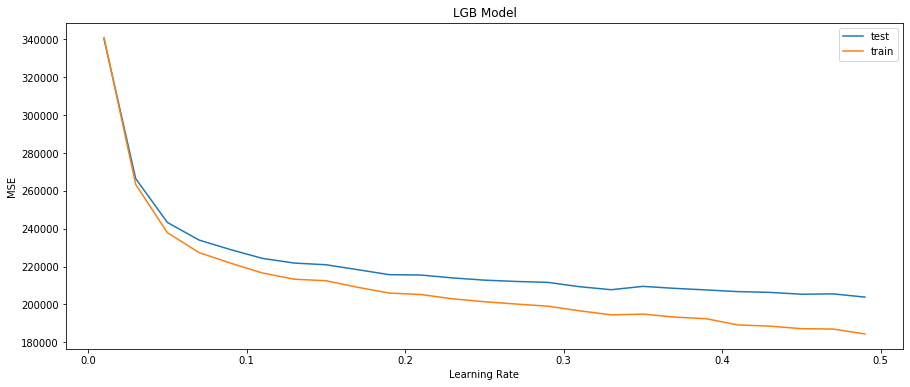

In [24]:
import lightgbm as lgb
import re
import copy

trainData2 = copy.deepcopy(trainData)
testData2 = copy.deepcopy(testData)
trainData2 = trainData.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
testData2 = testData.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

testAccuracies = []
trainAccuracies = []
for i in np.arange(0.01, 0.5, 0.02):
    gbm = lgb.LGBMRegressor(num_leaves=500,
                            learning_rate=i,
                            n_estimators=50,
                            max_depth=15,
                            min_data_in_leaf=30)
    gbm.fit(trainData2, trainAns,
            eval_set=[(testData2, testAns)],
            eval_metric='l1',
            early_stopping_rounds=5)
    pred = gbm.predict(testData2, num_iteration=gbm.best_iteration_)
    testAccuracies.append(np.sqrt(mean_squared_error(testAns, pred)))
    
    pred = gbm.predict(trainData2, num_iteration=gbm.best_iteration_)
    trainAccuracies.append(np.sqrt(mean_squared_error(trainAns, pred)))

print(min(testAccuracies))
plt.figure(figsize=(15,6))
plt.plot(np.arange(0.01, 0.5, 0.02), testAccuracies, label='test')
plt.plot(np.arange(0.01, 0.5, 0.02), trainAccuracies, label='train')
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.title('LGB Model')
plt.legend()
plt.show()

## Conclusion
As observed in the plots, the Light GBM model is performing the best and the mse is 203000 Toman which means our prediction varies 203000 Toman with real price which is acceptable. However, there were more possible solutions such as neural networks which I didn't implement because there wasn't enough time. Each feature of the dataset could be a neuron input in a neural network and it is possible that it works better than these models which are tested.<br>
Also, instead of adding words as features, TF-IDF measure could be used which calculates the possibility of a word appearing in a document but I didn't have the time to implement it. 